<a href="https://colab.research.google.com/github/FriendlyUser/finance-notebooks/blob/master/Stock_algorithms_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File not found...downloading the GOOG data


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


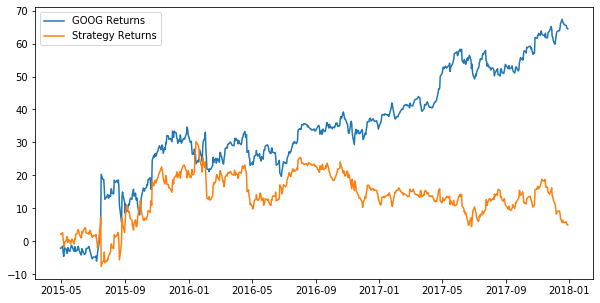

1.1703640059473464


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


from pandas_datareader import data
start_date = '2001-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME='goog_data_large.pkl'

try:
    goog_data = pd.read_pickle(SRC_DATA_FILENAME)
    print('File data found...reading GOOG data')
except FileNotFoundError:
    print('File not found...downloading the GOOG data')
    goog_data = data.DataReader('GOOG', 'yahoo', start_date, end_date)
    goog_data.to_pickle(SRC_DATA_FILENAME)

goog_data['Open-Close']=goog_data.Open-goog_data.Close
goog_data['High-Low']=goog_data.High-goog_data.Low
goog_data=goog_data.dropna()
X=goog_data[['Open-Close','High-Low']]
Y=np.where(goog_data['Close'].shift(-1)>goog_data['Close'],1,-1)

split_ratio=0.8
split_value=int(split_ratio * len(goog_data))
X_train=X[:split_value]
Y_train=Y[:split_value]
X_test=X[split_value:]
Y_test=Y[split_value:]


knn=KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, Y_train)
accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))




goog_data['Predicted_Signal']=knn.predict(X)
goog_data['GOOG_Returns']=np.log(goog_data['Close']/
                                 goog_data['Close'].shift(1))


def calculate_return(df,split_value,symbol):
    cum_goog_return= df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns']= df['%s_Returns' % symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return

def calculate_strategy_return(df,split_value):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_goog_return=calculate_return(goog_data,split_value=len(X_train),symbol='GOOG')
cum_strategy_return= calculate_strategy_return(goog_data,split_value=len(X_train))


def plot_shart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10,5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return,label='Strategy Returns')
    plt.legend()
    plt.show()

plot_shart(cum_goog_return, cum_strategy_return,symbol='GOOG')



# print(accuracy_train, accuracy_test)

# goog_data['Predicted_Signal']=knn.predict(X)
# goog_data['GOOG_Returns']=np.log(goog_data['Close']/
#                                  goog_data['Close'].shift(1))
# cum_goog_return=goog_data[split_value:]['GOOG_Returns'].cumsum()*100
#
# goog_data['Strategy_Returns']=goog_data['GOOG_Returns'] * goog_data['Predicted_Signal'].shift(1)
# cum_strategy_return=goog_data[split_value:]['Strategy_Returns'].cumsum()*100
#
# plt.figure(figsize=(10,5))
# plt.plot(cum_goog_return,label='GOOG Returns')
# plt.plot(cum_strategy_return,label='Strategy Returns')
# plt.legend()
# plt.show()


def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std=strategy_returns.std()
    sharpe=(strategy_returns-symbol_returns)/strategy_std
    return sharpe.mean()

print(sharpe_ratio(cum_strategy_return,cum_goog_return))

File data found...reading GOOG data


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


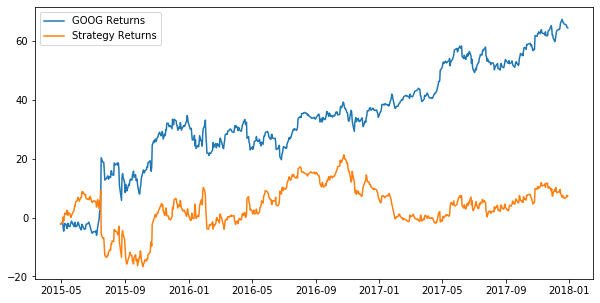

0.575780089153046 0.5074183976261127
1.7204465977722285


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


from pandas_datareader import data

def load_financial_data(start_date, end_date,output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        df = data.DataReader('GOOG', 'yahoo', start_date, end_date)
        df.to_pickle(output_file)
    return df

goog_data=load_financial_data(start_date='2001-01-01',
                    end_date = '2018-01-01',
                    output_file='goog_data_large.pkl')




def create_trading_condition(df):
    df['Open-Close']=df.Open-df.Close
    df['High-Low']=df.High-df.Low
    df=df.dropna()
    X=df[['Open-Close','High-Low']]
    Y=np.where(df['Close'].shift(-1)>df['Close'],1,-1)
    return (X,Y)

def create_train_split_group(X,Y,split_ratio=0.8):
    return train_test_split(X,Y,shuffle=False,train_size=split_ratio)

X,Y=create_trading_condition(goog_data)

X_train,X_test,Y_train,Y_test=\
    create_train_split_group(X,Y,split_ratio=0.8)

# Fit the model
svc=SVC()
svc.fit(X_train, Y_train)
# Forecast value

goog_data['Predicted_Signal']=svc.predict(X)
goog_data['GOOG_Returns']=np.log(goog_data['Close']/
                                 goog_data['Close'].shift(1))


def calculate_return(df,split_value,symbol):
    cum_goog_return= df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns']= df['%s_Returns' % symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return

def calculate_strategy_return(df,split_value):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_goog_return=calculate_return(goog_data,split_value=len(X_train),symbol='GOOG')
cum_strategy_return= calculate_strategy_return(goog_data,split_value=len(X_train))


def plot_shart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10,5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return,label='Strategy Returns')
    plt.legend()
    plt.show()

plot_shart(cum_goog_return, cum_strategy_return,symbol='GOOG')

def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std=strategy_returns.std()
    sharpe=(strategy_returns-symbol_returns)/strategy_std
    return sharpe.mean()

accuracy_train = accuracy_score(Y_train, svc.predict(X_train))
accuracy_test = accuracy_score(Y_test, svc.predict(X_test))
print(accuracy_train, accuracy_test)
print(sharpe_ratio(cum_strategy_return,cum_goog_return))

File data found...reading GOOG data


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


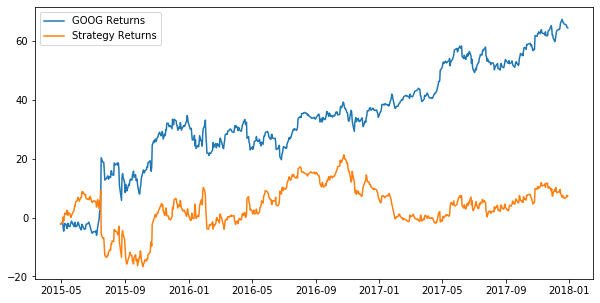

0.575780089153046 0.5074183976261127
1.7204465977722285


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


from pandas_datareader import data

def load_financial_data(start_date, end_date,output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        df = data.DataReader('GOOG', 'yahoo', start_date, end_date)
        df.to_pickle(output_file)
    return df

goog_data=load_financial_data(start_date='2001-01-01',
                    end_date = '2018-01-01',
                    output_file='goog_data_large.pkl')




def create_trading_condition(df):
    df['Open-Close']=df.Open-df.Close
    df['High-Low']=df.High-df.Low
    df=df.dropna()
    X=df[['Open-Close','High-Low']]
    Y=np.where(df['Close'].shift(-1)>df['Close'],1,-1)
    return (X,Y)

def create_train_split_group(X,Y,split_ratio=0.8):
    return train_test_split(X,Y,shuffle=False,train_size=split_ratio)

X,Y=create_trading_condition(goog_data)

X_train,X_test,Y_train,Y_test=\
    create_train_split_group(X,Y,split_ratio=0.8)

# Fit the model
svc=SVC()
svc.fit(X_train, Y_train)
# Forecast value

goog_data['Predicted_Signal']=svc.predict(X)
goog_data['GOOG_Returns']=np.log(goog_data['Close']/
                                 goog_data['Close'].shift(1))


def calculate_return(df,split_value,symbol):
    cum_goog_return= df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns']= df['%s_Returns' % symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return

def calculate_strategy_return(df,split_value):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_goog_return=calculate_return(goog_data,split_value=len(X_train),symbol='GOOG')
cum_strategy_return= calculate_strategy_return(goog_data,split_value=len(X_train))


def plot_shart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10,5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return,label='Strategy Returns')
    plt.legend()
    plt.show()

plot_shart(cum_goog_return, cum_strategy_return,symbol='GOOG')

def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std=strategy_returns.std()
    sharpe=(strategy_returns-symbol_returns)/strategy_std
    return sharpe.mean()

accuracy_train = accuracy_score(Y_train, svc.predict(X_train))
accuracy_test = accuracy_score(Y_test, svc.predict(X_test))
print(accuracy_train, accuracy_test)
print(sharpe_ratio(cum_strategy_return,cum_goog_return))

File data found...reading GOOG data
Coefficients: 
 [ 0.01681233 -0.04842961]
                 High        Low  ...  Predicted_Signal  GOOG_Returns
Date                              ...                                
2004-08-19  51.835709  47.800831  ...          0.266100           NaN
2004-08-20  54.336334  50.062355  ...          0.196232      0.076433
2004-08-23  56.528118  54.321388  ...          0.368790      0.010013
2004-08-24  55.591629  51.591621  ...          0.323984     -0.042289
2004-08-25  53.798351  51.746044  ...          0.356253      0.010718

[5 rows x 11 columns]


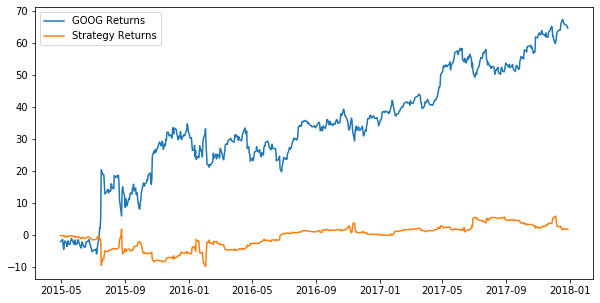

1.9722798340537153
Mean squared error: 27.52
Variance score: 0.00
Mean squared error: 103.38
Variance score: -0.01


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pandas_datareader import data

def load_financial_data(start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        df = data.DataReader('GOOG', 'yahoo', start_date, end_date)
        df.to_pickle(output_file)
    return df

def create_classification_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)
    return (df, X, Y)

def create_regression_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df['Target'] = df['Close'].shift(-1) - df['Close']
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = df[['Target']]
    return (df, X, Y)

def create_train_split_group(X, Y, split_ratio=0.8):
    return train_test_split(X, Y, shuffle=False, train_size=split_ratio)

goog_data = load_financial_data(
    start_date='2001-01-01',
    end_date='2018-01-01',
    output_file='goog_data_large.pkl')

goog_data, X, Y = create_regression_trading_condition(goog_data)

X_train,X_test,Y_train,Y_test=create_train_split_group(X,Y,split_ratio=0.8)

from sklearn import linear_model

# Fit the model
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train, Y_train)

# The coefficients
print('Coefficients: \n', lasso.coef_)

goog_data['Predicted_Signal'] = lasso.predict(X)
goog_data['GOOG_Returns'] = np.log(
    goog_data['Close'] / goog_data['Close'].shift(1))

print(goog_data.head())
def calculate_return(df, split_value, symbol):
    cum_goog_return = df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns'] = df['%s_Returns' %
                                symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return


def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return


cum_goog_return = calculate_return(
    goog_data, split_value=len(X_train), symbol='GOOG')
cum_strategy_return = calculate_strategy_return(
    goog_data, split_value=len(X_train), symbol='GOOG')


def plot_shart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.legend()
    plt.show()

plot_shart(cum_goog_return, cum_strategy_return, symbol='GOOG')


def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()


print(sharpe_ratio(cum_strategy_return, cum_goog_return))

from sklearn.metrics import mean_squared_error, r2_score

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_train, lasso.predict(X_train)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_train, lasso.predict(X_train)))

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, lasso.predict(X_test)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, lasso.predict(X_test)))

File data found...reading GOOG data
Coefficients: 
 [[ 0.02410177 -0.05781461]]
                 High        Low  ...  Predicted_Signal  GOOG_Returns
Date                              ...                                
2004-08-19  51.835709  47.800831  ...          0.281273           NaN
2004-08-20  54.336334  50.062355  ...          0.183888      0.076433
2004-08-23  56.528118  54.321388  ...          0.407256      0.010013
2004-08-24  55.591629  51.591621  ...          0.363848     -0.042289
2004-08-25  53.798351  51.746044  ...          0.387490      0.010718

[5 rows x 11 columns]


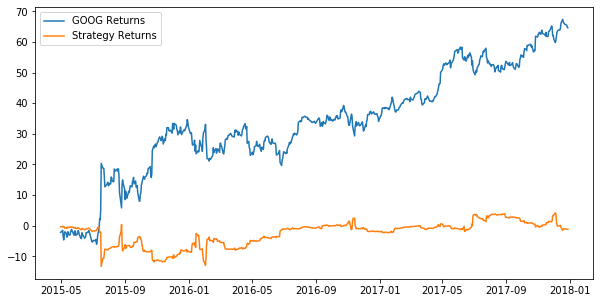

2.0840606780226065
Mean squared error: 27.52
Variance score: 0.00
Mean squared error: 103.50
Variance score: -0.01


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pandas_datareader import data

def load_financial_data(start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        df = data.DataReader('GOOG', 'yahoo', start_date, end_date)
        df.to_pickle(output_file)
    return df

def create_classification_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)
    return (df, X, Y)

def create_regression_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df['Target'] = df['Close'].shift(-1) - df['Close']
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = df[['Target']]
    return (df, X, Y)

def create_train_split_group(X, Y, split_ratio=0.8):
    return train_test_split(X, Y, shuffle=False, train_size=split_ratio)

goog_data = load_financial_data(
    start_date='2001-01-01',
    end_date='2018-01-01',
    output_file='goog_data_large.pkl')

goog_data, X, Y = create_regression_trading_condition(goog_data)

X_train,X_test,Y_train,Y_test=create_train_split_group(X,Y,split_ratio=0.8)

from sklearn import linear_model
# Fit the model
ols = linear_model.LinearRegression()
ols.fit(X_train, Y_train)
# Forecast value

# The coefficients
print('Coefficients: \n', ols.coef_)

goog_data['Predicted_Signal'] = ols.predict(X)
goog_data['GOOG_Returns'] = np.log(
    goog_data['Close'] / goog_data['Close'].shift(1))

print(goog_data.head())
def calculate_return(df, split_value, symbol):
    cum_goog_return = df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns'] = df['%s_Returns' %
                                symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return


def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return


cum_goog_return = calculate_return(
    goog_data, split_value=len(X_train), symbol='GOOG')
cum_strategy_return = calculate_strategy_return(
    goog_data, split_value=len(X_train), symbol='GOOG')


def plot_shart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.legend()
    plt.show()

plot_shart(cum_goog_return, cum_strategy_return, symbol='GOOG')


def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()


print(sharpe_ratio(cum_strategy_return, cum_goog_return))

from sklearn.metrics import mean_squared_error, r2_score

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_train, ols.predict(X_train)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_train, ols.predict(X_train)))

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, ols.predict(X_test)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, ols.predict(X_test)))

File data found...reading GOOG data
Coefficients: 
 [[ 0.01793866 -0.04383743]]
                 High        Low  ...  Predicted_Signal  GOOG_Returns
Date                              ...                                
2004-08-19  51.835709  47.800831  ...          0.257150           NaN
2004-08-20  54.336334  50.062355  ...          0.184475      0.076433
2004-08-23  56.528118  54.321388  ...          0.352393      0.010013
2004-08-24  55.591629  51.591621  ...          0.318638     -0.042289
2004-08-25  53.798351  51.746044  ...          0.337805      0.010718

[5 rows x 11 columns]


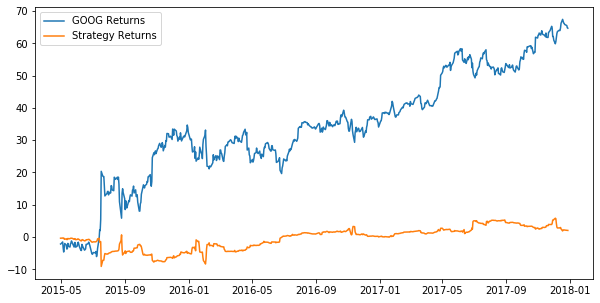

1.961576203516319
Mean squared error: 27.52
Variance score: 0.00
Mean squared error: 103.36
Variance score: -0.01


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pandas_datareader import data

def load_financial_data(start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        df = data.DataReader('GOOG', 'yahoo', start_date, end_date)
        df.to_pickle(output_file)
    return df

def create_classification_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)
    return (df, X, Y)

def create_regression_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df['Target'] = df['Close'].shift(-1) - df['Close']
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = df[['Target']]
    return (df, X, Y)

def create_train_split_group(X, Y, split_ratio=0.8):
    return train_test_split(X, Y, shuffle=False, train_size=split_ratio)

goog_data = load_financial_data(
    start_date='2001-01-01',
    end_date='2018-01-01',
    output_file='goog_data_large.pkl')

goog_data, X, Y = create_regression_trading_condition(goog_data)

X_train,X_test,Y_train,Y_test=create_train_split_group(X,Y,split_ratio=0.8)

from sklearn import linear_model

# Fit the model
ridge = linear_model.Ridge(alpha=10000)
ridge.fit(X_train, Y_train)

# The coefficients
print('Coefficients: \n', ridge.coef_)

goog_data['Predicted_Signal'] = ridge.predict(X)
goog_data['GOOG_Returns'] = np.log(
    goog_data['Close'] / goog_data['Close'].shift(1))

print(goog_data.head())
def calculate_return(df, split_value, symbol):
    cum_goog_return = df[split_value:]['%s_Returns' % symbol].cumsum() * 100
    df['Strategy_Returns'] = df['%s_Returns' %
                                symbol] * df['Predicted_Signal'].shift(1)
    return cum_goog_return


def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return


cum_goog_return = calculate_return(
    goog_data, split_value=len(X_train), symbol='GOOG')
cum_strategy_return = calculate_strategy_return(
    goog_data, split_value=len(X_train), symbol='GOOG')


def plot_shart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_symbol_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.legend()
    plt.show()

plot_shart(cum_goog_return, cum_strategy_return, symbol='GOOG')


def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()


print(sharpe_ratio(cum_strategy_return, cum_goog_return))

from sklearn.metrics import mean_squared_error, r2_score

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_train, ridge.predict(X_train)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_train, ridge.predict(X_train)))

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, ridge.predict(X_test)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_test, ridge.predict(X_test)))

File data found...reading GOOG data


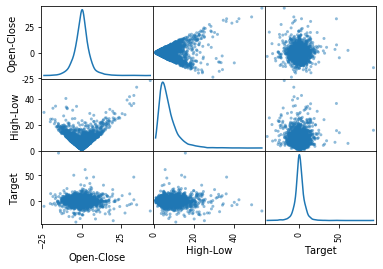

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

from pandas_datareader import data

def load_financial_data(start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        df = data.DataReader('GOOG', 'yahoo', start_date, end_date)
        df.to_pickle(output_file)
    return df

def create_regression_trading_condition(df):
    df['Open-Close'] = df.Open - df.Close
    df['High-Low'] = df.High - df.Low
    df['Target'] = df['Close'].shift(-1) - df['Close']
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    Y = df[['Target']]
    return (df, X, Y)

goog_data = load_financial_data(
    start_date='2001-01-01',
    end_date='2018-01-01',
    output_file='goog_data_large.pkl')

create_regression_trading_condition(goog_data)

pd.plotting.scatter_matrix(goog_data[['Open-Close', 'High-Low', 'Target']], grid=True, diagonal='kde', alpha=0.5)
plt.show()